In [1]:
import random
import re
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.functional as F
import matplotlib.pyplot as plt
import copy
from torch.nn.utils.rnn import pack_padded_sequence as PACK
from torch.nn.utils.rnn import pad_packed_sequence as PAD
from torch.optim.lr_scheduler import ReduceLROnPlateau
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
class DataSet(torch.utils.data.Dataset):
  def __init__(self, X, Y, Z):
    self.X = X
    self.Y = Y
    self.Z = Z
    if len(self.X) != len(self.Y) != len(self.Z):
      raise Exception("The length of X does not match the length of Y")

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    # note that this isn't randomly selecting. It's a simple get a single item that represents an x and y
    _x = self.X[index]
    _y = self.Y[index]
    _z = self.Z[index]

    return _x, _y, _z

In [3]:
x_train = np.load("x_train.npy")
x_train_pads = np.load("x_train_pads.npy")
y_train = np.load("y_train.npy")
x_val = np.load("x_val.npy")
x_val_pads = np.load("x_val_pads.npy")
y_val = np.load("y_val.npy")
x_test = np.load("x_test.npy")
x_test_pads = np.load("x_test_pads.npy")
y_test = np.load("y_test.npy")

x_train = torch.tensor(x_train, dtype=torch.float32, device=device)
x_val = torch.tensor(x_val, dtype=torch.float32, device=device)
x_test = torch.tensor(x_test, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
y_val = torch.tensor(y_val, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device)
x_train_pads = torch.tensor(x_train_pads, dtype=torch.int64, device="cpu")
x_val_pads = torch.tensor(x_val_pads, dtype=torch.int64, device="cpu")
x_test_pads = torch.tensor(x_test_pads, dtype=torch.int64, device="cpu")

train = DataSet(x_train, y_train, x_train_pads)
val = DataSet(x_val, y_val, x_val_pads)
test = DataSet(x_test, y_test, x_test_pads)

train = torch.utils.data.DataLoader(train, 256, shuffle=True)
val = torch.utils.data.DataLoader(val, 256, shuffle=False)
test = torch.utils.data.DataLoader(test, 256, shuffle=False)

In [4]:
class LSTMPredictor(nn.Module):
    def __init__(self, n_hidden, n_layers):
        super(LSTMPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.lstm = nn.LSTM(6, n_hidden, num_layers=n_layers, batch_first=True)
        self.linear_1 = nn.Linear(n_hidden, 512)
        self.linear_2 = nn.Linear(512, 256)
        self.lRelu = nn.LeakyReLU()
        self.linear_3 = nn.Linear(256, 1)

    def forward(self, x, hidden, input_len):   # -> input x:    (batch_size, seq_length, num_features)
        #print(x)
        x_pack = PACK(x, input_len, batch_first=True, enforce_sorted=False)
        x, hidden = self.lstm(x_pack, hidden) # -> LSTM out:   (batch_size, seq_length, hidden_size)
        x, input_sizes = PAD(x, batch_first=True)
        #print(input_sizes)
        x=x[torch.arange(len(x)), input_sizes-1]
        #print(x.shape)
        x = self.linear_1(x)
        x = self.lRelu(x)
        x = self.linear_2(x)
        x = self.lRelu(x)
        x = self.linear_3(x)

        #print(x.shape)
        x = x.flatten()

        return x, hidden

torch.Size([256, 8, 6])
torch.Size([256, 8, 6])
torch.Size([256, 8, 6])
torch.Size([228, 8, 6])
Validation Loss BASELINE: 2.8031
epoch 1
Training Loss: 172.5103
Validation Loss: 58.0776
Current LR 0.0005
epoch 2
Training Loss: 40.7403
Validation Loss: 14.9806
Current LR 0.0005
epoch 3
Training Loss: 13.4116
Validation Loss: 9.8809
Current LR 0.0005
epoch 4
Training Loss: 10.6699
Validation Loss: 8.9634
Current LR 0.0005
epoch 5
Training Loss: 10.0328
Validation Loss: 8.6894
Current LR 0.0005
epoch 6
Training Loss: 9.7805
Validation Loss: 8.5459
Current LR 0.0005
epoch 7
Training Loss: 9.6871
Validation Loss: 8.5011
Current LR 0.0005
epoch 8
Training Loss: 9.6485
Validation Loss: 8.4823
Current LR 0.0005
epoch 9
Training Loss: 9.6082
Validation Loss: 8.4906
Current LR 0.0005
epoch 10
Training Loss: 9.5956
Validation Loss: 8.4790
Current LR 0.0005
epoch 11
Training Loss: 9.6284
Validation Loss: 8.5116
Current LR 0.0005
epoch 12
Training Loss: 9.5899
Validation Loss: 8.5007
Current LR 0.0

<ipython-input-6-a59e699b2db4>:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(len(train_loss)))


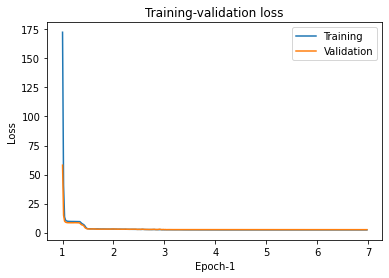

In [6]:
model = LSTMPredictor(n_hidden=64, n_layers=8)
model = model.to(device)
adam = torch.optim.Adam(model.parameters(), lr=0.0005)
mse = nn.MSELoss()
scheduler = ReduceLROnPlateau(adam, 'min', patience = 10, factor=0.5)
train_size = 9311
val_size = 1164

# Will automatically restore weights from epoch with best validation accuracy
def train_model(model, loss_f, optimizer, num_epochs):
    best_model_weights = copy.deepcopy(model.state_dict())
    best_model_acc = 0.0
    train_loss = np.zeros(num_epochs)
    train_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    for epoch in range(num_epochs):
        print("epoch",epoch+1)
        running_loss = 0.0
        running_corrects = 0
        torch.set_grad_enabled(True)
        best_loss = 9999
        model.train()
        for batch_idx, batch in enumerate(train):
            model.zero_grad()
            inputs, labels, input_len = batch
            inputs, labels = inputs.to(device), labels.to(device)
            #Forward
            out, hidden = model(inputs, None, input_len)

            #print(out)
            #print(labels)

            #Compute objective function
            loss = loss_f(out, labels)

            #Accumulate partial deriviates wrt parameters
            loss.backward()

            #Step in the opposite direction og the gradient wrt optimizer
            optimizer.step()

            #stats
            running_loss += loss.item() * inputs.size(0)

        train_loss[epoch] = running_loss / train_size
        #train_acc[epoch] = running_corrects.double() / train_size
        print('Training Loss: {:.4f}'.format(train_loss[epoch]))
        running_loss = 0.0
        running_corrects = 0
        for batch_idx, batch in enumerate(val):
            model.eval()

            inputs, labels, input_len = batch

            #Move to gpu if availible
            inputs, labels = inputs.to(device), labels.to(device)

            #Forward
            with(torch.no_grad()):
                out, hidden = model(inputs, None, input_len)

            #Compute objective function
            loss = loss_f(out, labels)
            running_loss += loss.item() * inputs.size(0)

        val_loss[epoch] = running_loss / val_size
        scheduler.step(val_loss[epoch])

        curr_lr = optimizer.param_groups[0]['lr']
        print('Validation Loss: {:.4f}'.format(val_loss[epoch]))
        print("Current LR", curr_lr)

        # deep copy the model
        if (val_loss[epoch] < best_loss):
            best_loss = val_acc[epoch]
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model, train_acc, train_loss, val_acc, val_loss


def find_baseline():
    loss_m = nn.MSELoss()
    running_loss = 0
    for batch_idx, batch in enumerate(val):
        inputs, labels, input_len = batch
        print(inputs.shape)
        #Move to gpu if availible
        preds = torch.zeros(labels.shape, device=device)
        for i in range(len(inputs)):
            for j in range(input_len[i]-1, -1, -1):
                if inputs[i, j, -2] != 0.0:
                    preds[i] = inputs[i, j, -2]*60
                    break
        #print(preds)
        #print(labels)

        #Compute objective function
        loss = loss_m(preds, labels)
        running_loss += loss.item() * inputs.size(0)

    val_loss_baseline = running_loss / val_size
    print('Validation Loss BASELINE: {:.4f}'.format(val_loss_baseline))

find_baseline()

model, train_acc, train_loss, val_acc, val_loss = train_model(model, mse, adam, 300)
torch.save(model, "model")

fig, ax = plt.subplots()
ax.plot(train_loss, label="Training")
ax.plot(val_loss, label="Validation")
ax.set_xticklabels(np.arange(len(train_loss)))
plt.xlabel("Epoch-1")
plt.ylabel("Loss")
plt.title("Training-validation loss")
plt.legend()
plt.show()

In [8]:
model = torch.load("model")

def make_prediction(klasser, tider):
    x = torch.zeros((8, 6), dtype=torch.float32)
    length = len(klasser)
    for i in range(length):
        x[i] =  generate_class(klasser[i], x[i])
        if x[i,-1] == 0:
            x[i,4] = generate_time(tider[i][0], tider[i][1])
    print(x)
    hidden = None
    x = x.view(-1, len(x), len(x[0]))
    x = x.to(device)
    lengths = torch.tensor([length], dtype=torch.int64)
    out, _ = model(x, hidden, lengths)
    print_time(out[0])
    for i in range(8-length):
        j = 1
        while sum(x[0,length+i-j,:4]) == 0:
            j += 1
        x[0,length+i,:4] = x[0,length+i-j,:4]
        x[0,length+i,4] = out[0]/60
        lengths = torch.tensor([length+i+1], dtype=torch.int64)
        out, _ = model(x, hidden, lengths)
        print_time(out[0])
    print(x)



def print_time(time):
    minutes = int(time)
    seconds = int((time-int(time))*60)
    print("Stoltzen in: {} minutes {} seconds".format(minutes, seconds))

def generate_time(min, sec):
    time = min + (sec/60)
    time = time/60
    return time

def generate_class(klasse, x):
    x[int(klasse[1])-1] = 1
    return x

klasser = ["m1", "m1", "m1"]
tider = [(16,00), (15,30), (14,00)]
make_prediction(klasser, tider)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.2667, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.2583, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.2333, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
Stoltzen in: 14 minutes 51 seconds
Stoltzen in: 14 minutes 51 seconds
Stoltzen in: 14 minutes 53 seconds
Stoltzen in: 15 minutes 7 seconds
Stoltzen in: 15 minutes 12 seconds
Stoltzen in: 14 minutes 55 seconds
tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.2667, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.0000, 0.2583, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.0000, 0.2333, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.0000, 0.2476, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.0000, 0.2477, 0.0000],
         [1.0000, 0.0000, 0.000